###Import the libraries

In [ ]:
## for data
import numpy as np
import pandas as pd

## for plotting
import matplotlib.pyplot as plt
%matplotlib inline

## for word cloud
import wordcloud
from wordcloud import STOPWORDS
from wordcloud import WordCloud

## for eda
from collections import Counter

## for w2v
from gensim.models import Word2Vec

## for fasttext
from gensim.models.fasttext import FastText

## for processing
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

## for preparation
from sklearn.model_selection import train_test_split

## for vectorizing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## for models
from sklearn.naive_bayes import MultinomialNB
from sklearn import  model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn.metrics import accuracy_score

## for tokenization
from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer

## for building network
from keras.layers import Dense, LSTM, Embedding, GRU
from keras.models import Sequential


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


###Data Import

In [ ]:
train = pd.read_parquet('train.parquet', engine='pyarrow')
train.head()

,Body,Tags,Title,target
Id,,,,
34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2
47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2
46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0
45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0
49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1


In [ ]:
train.describe()

,target
count,48000.000000
mean,1.000000
std,0.816505
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


In [ ]:
test = pd.read_parquet('test.parquet', engine='pyarrow')
test.head()

,Body,Tags,Title
Id,,,
46785369,I was given a decision tree with sample data i...,<math><machine-learning><artificial-intelligen...,Desecion trees ended up with same given tree a...
38908667,<p>I am moving a test application over to Xcod...,<ios><swift><swift3><xcode8><nserror>,Value of type 'Error' has no member 'code'
44703012,<p>I would like to be able to perform linting ...,<jenkins><jenkins-pipeline>,How do I lint Jenkins pipelines from the comma...
34910435,"<p>I’m using <a href=""https://github.com/ftlab...",<javascript><css><mobile-safari><fastclick.js>...,Is there a way to prevent fastclick from firin...
51632121,I have some 5 Test cases and I want them to ke...,<android><testing><appium><katalon-studio>,How to loop test cases in katalon Studio?


In [ ]:
test.describe()

,Body,Tags,Title
count,12000,12000,12000
unique,12000,7858,12000
top,16*16 matrix is coming to my screen when i sta...,<java>,Change Double Number displaying format?
freq,1,203,1


In [ ]:
submission = pd.read_csv("sample_submission.csv")
submission.head()

,Id,Predicted
0,46785369,0
1,38908667,0
2,44703012,0
3,34910435,0
4,51632121,0


In [ ]:
train['Text'] = train['Title'] + train['Body'] 

train.drop(['Title', 'Body', 'Tags'], axis=1, inplace=True)
train.head()

,target,Text
Id,,
34862324,2,I am implementing a Minimum Spanning Forrest a...
47303682,2,"R Studio: Date is getting converted to number,..."
46431243,0,Pandas - dataframe groupby - how to get sum of...
45306324,0,Casting results from Observable.forkJoin to th...
49479547,1,Environment variable set in batch file cannot ...


In [ ]:
test['Text'] = test['Title'] + test['Body'] 

test.drop(['Title', 'Body', 'Tags'], axis=1, inplace=True)
test.head()

,Text
Id,
46785369,Desecion trees ended up with same given tree a...
38908667,Value of type 'Error' has no member 'code'<p>I...
44703012,How do I lint Jenkins pipelines from the comma...
34910435,Is there a way to prevent fastclick from firin...
51632121,How to loop test cases in katalon Studio?I hav...


###Preprocessing Data 

In [ ]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

Cleaning data

In [ ]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if len(token)>=3:
         if stem:
            tokens.append(stemmer.stem(token))
         else:
            tokens.append(token)
  return " ".join(tokens)

In [ ]:
train.Text = train.Text.apply(lambda x: preprocess(x))
train.head()

,target,Text
Id,,
34862324,2,implementing minimum spanning forrest algorihm...
47303682,2,studio date getting converted number making ht...
46431243,0,pandas dataframe groupby get sum multiple colu...
45306324,0,casting results observable forkjoin respective...
49479547,1,environment variable set batch file cannot acc...


In [ ]:
test.Text = test.Text.apply(lambda x: preprocess(x))
test.head()

,Text
Id,
46785369,desecion trees ended given tree gain split com...
38908667,value type error member code moving test appli...
44703012,lint jenkins pipelines command line would like...
34910435,way prevent fastclick firing active state scro...
51632121,loop test cases katalon studio test cases want...


###EDA

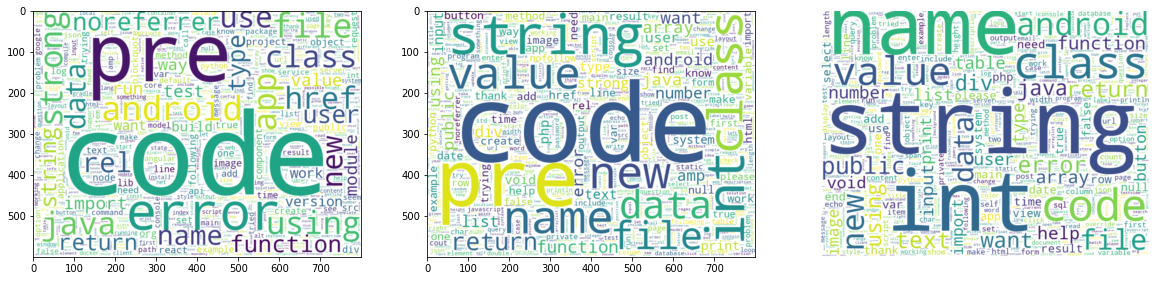

In [ ]:
# WordCloud for HighQuality Posts

text = " ".join(train[train['target']==0]['Text'])
text_1 = " ".join(train.loc[train['target']==1]['Text'])
text_2 = " ".join(train.loc[train['target']==2]['Text'])

# Create and generate a word cloud image:
wc = WordCloud(background_color='white',max_words = 1000 , width = 800 , height = 600, stopwords = STOPWORDS, collocations=False).generate(text)
wc_1 = WordCloud(background_color='white',max_words = 1000 , width = 800 , height = 600 , stopwords = STOPWORDS, collocations=False).generate(text_1)
wc_2 = WordCloud(background_color='white',max_words = 1000 , width = 800 , height = 600 , stopwords = STOPWORDS, collocations=False).generate(text_2)


# Display the generated image:
fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax[0].imshow(wc, interpolation='bilinear')
ax[1].imshow(wc_1, interpolation='bilinear')
ax[2].imshow(wc_2, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
words_collection = Counter([item for item in train[train['target']==0]['Text'].apply(lambda x:str(x).split()) for item in item])
freq_word = pd.DataFrame(words_collection.most_common(10))
freq_word.columns = ['Word ',' Count']
freq_word.style.background_gradient(cmap='YlOrRd', low=0, high=0, axis=0, subset=None)


,Word,Count
0,code,90868
1,pre,38626
2,error,10021
3,android,9767
4,strong,8959
5,app,8710
6,using,8535
7,java,8246
8,class,8012
9,href,7799


In [ ]:
words_collection = Counter([item for item in train[train['target']==1]['Text'].apply(lambda x:str(x).split()) for item in item])
freq_word_1 = pd.DataFrame(words_collection.most_common(10))
freq_word_1.columns = ['Word ',' Count']
freq_word_1.style.background_gradient(cmap='YlOrRd', low=0, high=0, axis=0, subset=None)

,Word,Count
0,code,47231
1,pre,27341
2,string,10051
3,int,9786
4,class,7942
5,new,6926
6,name,6763
7,data,6560
8,get,5730
9,java,5699


In [ ]:
words_collection = Counter([item for item in train[train['target']==2]['Text'].apply(lambda x:str(x).split()) for item in item])
freq_word_2 = pd.DataFrame(words_collection.most_common(10))
freq_word_2.columns = ['Word ',' Count']
freq_word_2.style.background_gradient(cmap='YlOrRd', low=0, high=0, axis=0, subset=None)

,Word,Count
0,string,11355
1,int,10597
2,class,10076
3,code,9472
4,name,9464
5,android,9457
6,new,9245
7,data,7494
8,value,7064
9,public,6891


In [ ]:
words_collection = Counter([item for item in train['Text'].apply(lambda x:str(x).split()) for item in item])

In [ ]:
freq_word_df = pd.DataFrame(words_collection.most_common(10))

Text(0, 0.5, 'Count')

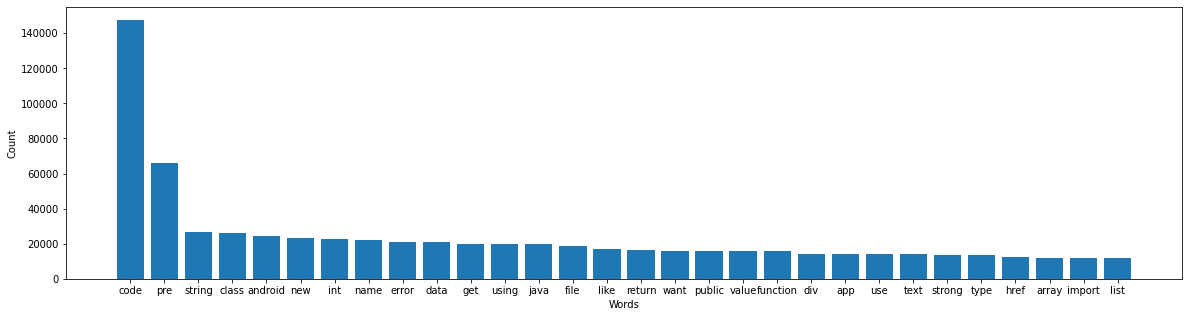

In [ ]:
words_collection_all = Counter([item for item in train['Text'].apply(lambda x:str(x).split()) for item in item])
freq_word_all = pd.DataFrame(words_collection_all.most_common(30))
fig,ax=plt.subplots(figsize=(20, 5))
ax.bar(freq_word_all[0],freq_word_all[1])
plt.xlabel('Words')
plt.ylabel('Count')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  after removing the cwd from sys.path.


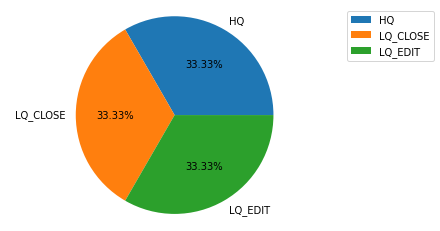

In [ ]:
fig1, ax1 = plt.subplots()
labels=['HQ','LQ_CLOSE','LQ_EDIT']
sizes= train.groupby('target').count()
wedges, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.2f%%')
ax1.axis('equal')
ax1.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

###Train and Test Split

In [ ]:
#train data
X = train['Text']
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21)

In [ ]:
#test data    
test_data_x = test["Text"]

###Vectorizing Data

1. Bow

In [ ]:
count_vectorizer = CountVectorizer(ngram_range = (1,1), min_df = 1)
X_train_vectors = count_vectorizer.fit_transform(X_train)
X_test_vectors = count_vectorizer.transform(X_test)

test_data_x_vectors = count_vectorizer.transform(test_data_x)

NameError: ignored

2. Tf-idf

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df = 2, max_df = 0.5)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

test_data_x_tfidf = tfidf.transform(test_data_x)

###Models

1. MultinomialNB

In [ ]:
NB_tfidf = MultinomialNB()
NB_tfidf.fit(X_train_tfidf, y_train)
predictions_tfidf = NB_tfidf.predict(X_test_tfidf)

print ("Accuracy of NB tfidf: ", accuracy_score(predictions_tfidf, y_test))

Accuracy of NB tfidf:  0.7376388888888888


In [ ]:
NB_bow = MultinomialNB()
NB_bow.fit(X_train_vectors, y_train)
predictions_bow = NB_bow.predict(X_test_vectors)

print ("Accuracy of NB bow: ", accuracy_score(predictions_bow, y_test))

Accuracy of NB bow:  0.6993055555555555


*NB показывает точность выше при использовании TFIDF векторизации*

2. Logistic Regression

In [ ]:
logitreg_tfidf = LogisticRegression(penalty='l2', C = 0.03, solver='lbfgs', max_iter = 300, random_state = 10)
logitreg_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = logitreg_tfidf.predict(X_test_tfidf)
print("Accuracy of Logistic Regression model tfidf : ", accuracy_score(y_pred_tfidf, y_test))

Accuracy of Logistic Regression model tfidf :  0.7561111111111111


In [ ]:
logreg_bow = LogisticRegression(penalty='l2', C = 0.03, solver='lbfgs', max_iter = 300, random_state = 10)
logreg_bow.fit(X_train_vectors, y_train)
y_pred_vec = logreg_bow.predict(X_test_vectors)
print("Accuracy of Logistic Regression model bow: ", accuracy_score(y_pred_vec, y_test))

Accuracy of Logistic Regression model bow:  0.8124305555555555


*Это лучшая точность при использовании данных моделей*

*Классифицуруем тестовый набор данных*

In [ ]:
predictions_bow_result = logreg_bow.predict(test_data_x_vectors)

In [ ]:
submission["Predicted"] = predictions_bow_result
sub_file_lgr_bow = pd.DataFrame({"Id" : submission['Id'], "Predicted": submission["Predicted"]})
sub_file_lgr_bow.to_csv("submission3.csv", index = False)

3. Random Forest

In [ ]:
rf_tfidf = ensemble.RandomForestClassifier(n_estimators = 100)
rf_tfidf.fit(X_train_tfidf, y_train)
ypred_tfidf = rf_tfidf.predict(X_test_tfidf)

print ("Accuracy Random Forest: ", accuracy_score(ypred_tfidf, y_test))

Accuracy Random Forest:  0.8015277777777777


In [ ]:
rf_bow = ensemble.RandomForestClassifier(n_estimators = 100)
rf_bow.fit(X_train_vectors, y_train)
ypred_bow = rf_bow.predict(X_test_vectors)

print ("Accuracy Random Forest: ", accuracy_score(ypred_bow, y_test,))

Accuracy Random Forest:  0.7876388888888889


Возможно стоит лучше предобработать текст, чтобы RF показал себя и более высокую точность

#--------------------

#Word Embedding

Tokinization

1. Word2Vec

In [ ]:
all_text = X_train.append(X_test)

In [ ]:
w2v_model = Word2Vec(min_count=10, window=2, size=100, negative=10, alpha=0.03, min_alpha=0.0007, sample=6e-5,sg=1)
w2v_model.build_vocab(all_text.apply(lambda x: (str(x).split())))
w2v_model.train(all_text.apply(lambda x: (str(x).split())), total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(59969922, 123722550)

In [ ]:
w2v_model.wv.most_similar('use')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('using', 0.699678897857666),
 ('used', 0.6690715551376343),
 ('know', 0.6678149700164795),
 ('way', 0.6157210469245911),
 ('possible', 0.6085492372512817),
 ('want', 0.5995333194732666),
 ('trying', 0.5948939919471741),
 ('work', 0.5857999324798584),
 ('like', 0.5829079151153564),
 ('also', 0.5795086622238159)]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 131822


In [ ]:
MAX_SEQUENCE_LENGTH = 30


In [ ]:
x_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

data_test_seq = pad_sequences(tokenizer.texts_to_sequences(test_data_x),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train_seq.shape)
print("Testing X Shape:",x_test_seq.shape)
print("Testing data X Shape:",data_test_seq.shape)

Training X Shape: (33600, 30)
Testing X Shape: (14400, 30)
Testing data X Shape: (12000, 30)


In [ ]:
EMBEDDING_DIM = 300 # recommended size

embendding matrix for embendding layer

In [ ]:
embeddings_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, idx in tokenizer.word_index.items():
    try:
        embedding = w2v_model[word]
        embeddings_matrix[idx] = embedding
    except:
        pass

embedding_layer = Embedding(vocab_size,
                            EMBEDDING_DIM,
                            weights=[embeddings_matrix],
                            trainable=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [ ]:
embeddings_matrix.shape

(131822, 300)

Building network

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(GRU(300))
model.add(Dense(units=1, activation='sigmoid'))
 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 300)         39546600  
_________________________________________________________________
gru_5 (GRU)                  (None, 300)               541800    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 301       
Total params: 40,088,701
Trainable params: 542,101
Non-trainable params: 39,546,600
_________________________________________________________________
None


In [ ]:
history = model.fit(x_train_seq, y_train, batch_size=256, epochs=5, validation_data=(x_test_seq, y_test))

Epoch 1/5
132/132 [==============================] - 3s 19ms/step - loss: -5.5403 - accuracy: 0.4343 - val_loss: -9.7653 - val_accuracy: 0.4714
Epoch 2/5
132/132 [==============================] - 2s 16ms/step - loss: -12.0210 - accuracy: 0.4235 - val_loss: -7.8925 - val_accuracy: 0.3826
Epoch 3/5
132/132 [==============================] - 2s 16ms/step - loss: -17.0145 - accuracy: 0.4257 - val_loss: -22.7698 - val_accuracy: 0.4381
Epoch 4/5
132/132 [==============================] - 2s 16ms/step - loss: -18.9076 - accuracy: 0.4282 - val_loss: -17.9902 - val_accuracy: 0.3809
Epoch 5/5
132/132 [==============================] - 2s 16ms/step - loss: -22.0294 - accuracy: 0.4095 - val_loss: -11.6633 - val_accuracy: 0.4357


In [ ]:
score = model.evaluate(x_test_seq, y_test, batch_size=256)
print()
print("Accuracy:",score[1])
print("loss:",score[0])

57/57 [==============================] - 0s 8ms/step - loss: -11.6633 - accuracy: 0.4357

Accuracy: 0.43569445610046387
loss: -11.663337707519531


2. FastText

In [ ]:
all_text_ft = X_train.append(X_test)

In [ ]:
fasttext_model = FastText( size=60,  window=2, min_count=10,  sample=6e-5, sg=1,  iter=50)
fasttext_model.build_vocab(all_text_ft.apply(lambda x: (str(x).split())))
fasttext_model.train(all_text_ft.apply(lambda x: (str(x).split())), total_examples=fasttext_model.corpus_count, epochs=30) 

In [ ]:
print(fasttext_model.wv['code'])

[-0.67657703 -0.27353474 -0.04139931 -0.36477888  0.32651424 -0.07071029
 -0.21238494 -0.01288479 -0.18584369 -0.00775714 -0.04724901 -0.16689509
  0.05676824 -0.0340964   0.20122541 -0.11379307  0.11683817 -0.20128599
  0.07214443 -0.18277754 -0.11416598 -0.24400681  0.19252352  0.01448672
  0.04620533 -0.27063322 -0.14947562  0.06763614 -0.11904406 -0.09186523
 -0.18321423 -0.16330269 -0.11307752 -0.19651188  0.00196713  0.00178768
 -0.08319285 -0.09289169  0.00521965  0.09656345 -0.06629025  0.28721544
 -0.28947556 -0.218565   -0.18245253  0.08247042 -0.16189545 -0.32505453
  0.05832061  0.05337396 -0.14924115  0.00577388 -0.16537522 -0.07398641
 -0.20711908 -0.06786878  0.37516862 -0.17879622  0.08876804  0.4151111 ]


In [ ]:
similar_words = {words: [item for item in fasttext_model.wv.most_similar([words], topn=3)]
                  for words in ['code', 'error', 'app']}

for k,v in similar_words.items():
    print(k+":"+str(v))

code:[('pre', 0.961652398109436), ('following', 0.874993085861206), ('however', 0.8138596415519714)]
error:[('errors', 0.8376143574714661), ('saying', 0.8133574724197388), ('getting', 0.8034521341323853)]
app:[('wrap12', 0.742142379283905), ('handlebindapplication', 0.7368415594100952), ('installprovider', 0.7294424176216125)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


matrix for embendding layer

In [ ]:
embeddings_matrix_ft = np.zeros((vocab_size, EMBEDDING_DIM))
for word, idx in tokenizer.word_index.items():
    try:
        embedding = fasttext_model[word]
        embeddings_matrix_ft[idx] = embedding
    except:
        pass

embedding_layer = Embedding(vocab_size,
                            EMBEDDING_DIM,
                            weights=[embeddings_matrix_ft],
                            trainable=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [ ]:
embeddings_matrix_ft.shape

(131822, 300)

Building network

In [ ]:
model_ft = Sequential()
model_ft.add(embedding_layer)
model_ft.add(GRU(300))
model_ft.add(Dense(units=1, activation='sigmoid'))
 
model_ft.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_ft.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 300)         39546600  
_________________________________________________________________
gru_6 (GRU)                  (None, 300)               541800    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 301       
Total params: 40,088,701
Trainable params: 542,101
Non-trainable params: 39,546,600
_________________________________________________________________
None


In [ ]:
history_ft = model_ft.fit(x_train_seq, y_train, batch_size=256, epochs=5, validation_data=(x_test_seq, y_test))

Epoch 1/5
132/132 [==============================] - 3s 20ms/step - loss: 0.0898 - accuracy: 0.3322 - val_loss: -0.0631 - val_accuracy: 0.3372
Epoch 2/5
132/132 [==============================] - 2s 16ms/step - loss: 0.0279 - accuracy: 0.3317 - val_loss: -0.0522 - val_accuracy: 0.3372
Epoch 3/5
132/132 [==============================] - 2s 15ms/step - loss: 0.0320 - accuracy: 0.3317 - val_loss: -0.0491 - val_accuracy: 0.3372
Epoch 4/5
132/132 [==============================] - 2s 16ms/step - loss: 0.0253 - accuracy: 0.3317 - val_loss: -0.0479 - val_accuracy: 0.3372
Epoch 5/5
132/132 [==============================] - 2s 15ms/step - loss: 0.0299 - accuracy: 0.3317 - val_loss: -0.0498 - val_accuracy: 0.3372


In [ ]:
score_ft = model_ft.evaluate(x_test_seq, y_test, batch_size=256)
print()
print("Accuracy:",score_ft[1])
print("loss:",score_ft[0])

57/57 [==============================] - 0s 8ms/step - loss: -0.0498 - accuracy: 0.3372

Accuracy: 0.33715277910232544
loss: -0.049785859882831573


Нейронные сети показали плохой результат, хотя должны были оказаться самой лучшей версией. На это возможно повлияла плоха предобработка текста или стоило получше поиграться с гиперпараметрами :(

Или получше обучить  эмбеддинги, чтобы увеличить точность, а так даже порог в 0.6 не удалось перескочить